This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.6: Ridge Regression and the Lasso

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [2]:
df = pd.read_csv('Hitters.csv').dropna()
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [3]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


# 6.6.1 Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [4]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [5]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
coefs

[array([ 2.41792033e-10,  8.77087820e-10,  3.53418911e-09,  1.48322166e-09,
         1.56674826e-09,  1.84396625e-09,  7.54102361e-09,  2.07601888e-11,
         7.64034224e-11,  5.76187223e-10,  1.53282320e-10,  1.58190714e-10,
         1.67364484e-10,  9.68457013e-11,  1.58184041e-11, -7.37555427e-11,
        -2.57640933e-09, -3.46788982e-08, -5.11835167e-10]),
 array([ 3.19634838e-10,  1.15945848e-09,  4.67199001e-09,  1.96073175e-09,
         2.07114900e-09,  2.43761486e-09,  9.96878940e-09,  2.74437478e-11,
         1.01000828e-10,  7.61685599e-10,  2.02630206e-10,  2.09118814e-10,
         2.21245998e-10,  1.28024318e-10,  2.09109993e-11, -9.75004868e-11,
        -3.40586150e-09, -4.58434625e-08, -6.76615963e-10]),
 array([ 4.22538444e-10,  1.53273587e-09,  6.17609583e-09,  2.59197198e-09,
         2.73793708e-09,  3.22238339e-09,  1.31781529e-08,  3.62790194e-11,
         1.33517150e-10,  1.00690354e-09,  2.67865207e-10,  2.76442765e-10,
         2.92474189e-10,  1.69240613e-10, 

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

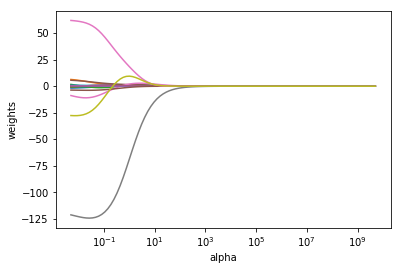

In [6]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [7]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [8]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred2))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred2))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred2),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred2))          # Calculate the test R2

AtBat           0.091443
Hits            0.450567
HmRun           1.254474
Runs            0.836145
RBI             0.736158
Walks           0.867846
Years           2.153183
CAtBat          0.007468
CHits           0.030280
CHmRun          0.237408
CRuns           0.061454
CRBI            0.068291
CWalks          0.064104
PutOuts         0.057609
Assists         0.026999
Errors         -0.013825
League_N        3.145268
Division_W    -43.511323
NewLeague_N    -4.638978
dtype: float64
Average Salary: 550.073053030303
MAE: 244.20189931358763
MSE: 114216.27659878535
MAPE: 86.95609237680456 %
R2Score: 0.38417835350521845


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [9]:
from sklearn.metrics import r2_score
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
#print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients

print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred3))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred3))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred3),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred3))          # Calculate the test R2

Average Salary: 550.073053030303
MAE: 326.75065504997485
MSE: 186276.4259526658
MAPE: 124.36604182301399 %
R2Score: -0.004349456569080923


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [10]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred))          # Calculate the test R2

AtBat           -2.269841
Hits             5.505078
HmRun            3.002796
Runs             5.759770
RBI             -0.930001
Walks            1.272078
Years           -3.812737
CAtBat          -0.365131
CHits            0.456880
CHmRun          -2.391901
CRuns            0.959694
CRBI             2.032048
CWalks          -0.082049
PutOuts          0.233520
Assists          0.632799
Errors          -3.260460
League_N        33.748361
Division_W    -163.017282
NewLeague_N     17.605455
dtype: float64
Average Salary: 550.073053030303
MAE: 249.42773373688627
MSE: 109663.47312605345
MAPE: 79.78699443343247 %
R2Score: 0.40872577366490115


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [11]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

pred11 = ridgecv.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred11))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred11))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred11),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred11))          # Calculate the test R2
ridgecv.alpha_

AtBat           -2.269841
Hits             5.505078
HmRun            3.002796
Runs             5.759770
RBI             -0.930001
Walks            1.272078
Years           -3.812737
CAtBat          -0.365131
CHits            0.456880
CHmRun          -2.391901
CRuns            0.959694
CRBI             2.032048
CWalks          -0.082049
PutOuts          0.233520
Assists          0.632799
Errors          -3.260460
League_N        33.748361
Division_W    -163.017282
NewLeague_N     17.605455
dtype: float64
Average Salary: 550.073053030303
MAE: 226.54529162719604
MSE: 98047.63889173509
MAPE: 77.47494501941982 %
R2Score: 0.471355044873909


0.5748784976988678

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [12]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
pred4 = ridge4.predict(X_test)
mean_squared_error(y_test, ridge4.predict(X_test))


98047.6388917346

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [13]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversi

Text(0, 0.5, 'weights')

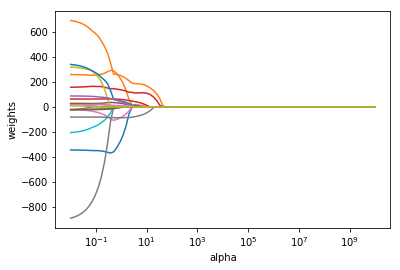

In [14]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [15]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))
pred7=lasso.predict(X_test)
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred7))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred7))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred7),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred7))          # Calculate the test R2

Average Salary: 550.073053030303
MAE: 239.37830419496
MSE: 101541.335204902
MAPE: 78.22723992887522 %
R2Score: 0.4525180289949473


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [16]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           -1.833403
Hits             4.864618
HmRun           -0.000000
Runs             5.089176
RBI              0.000000
Walks            1.324852
Years          -17.276302
CAtBat          -0.000000
CHits            0.000000
CHmRun          -0.000000
CRuns            0.130603
CRBI             0.724423
CWalks          -0.000000
PutOuts          0.224421
Assists          0.321669
Errors          -0.832555
League_N        20.144903
Division_W    -172.648705
NewLeague_N      0.000000
dtype: float64

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
elas = ElasticNet(alpha=0.01)
elascv = ElasticNetCV(cv=10, random_state=0)
elascv.fit(X_train, y_train)

elas.set_params(alpha=elascv.alpha_,l1_ratio=elascv.l1_ratio)
elas.fit(X_train, y_train)

pred10=elas.predict(X_test)
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred10))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred10))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred10),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred10))          # Calculate the test R2
elascv.l1_ratio

Average Salary: 550.073053030303
MAE: 217.41376346385465
MSE: 96095.75091591016
MAPE: 76.70740863236315 %
R2Score: 0.4818790691447077


0.5

In [18]:
from sklearn.feature_selection import SelectFromModel
sel_model = SelectFromModel(lassocv, prefit=True)
sel_model.get_support()

array([ True,  True, False,  True, False,  True,  True, False, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False])

In [19]:
selected_feat = X_train.columns[(sel_model.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))


total features: 19
selected features: 12


In [20]:
X_train_selected = sel_model.transform(X_train.fillna(0))
X_test_selected = sel_model.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape

((131, 12), (132, 12))

In [21]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train_selected, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_selected, y_train)
pred8=lasso.predict(X_test_selected)
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred8))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred8))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred8),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred8))          # Calculate the test R2

Average Salary: 550.073053030303
MAE: 244.99016657840772
MSE: 104513.27258899309
MAPE: 78.40739521754098 %
R2Score: 0.4364941887188424


In [22]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train_selected, y_train)

ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(X_train_selected, y_train)
pred9=ridge.predict(X_test_selected)
print("Average Salary:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred9))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred9))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred9),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred9))          # Calculate the test R2

Average Salary: 550.073053030303
MAE: 243.93208769908097
MSE: 102907.53202732725
MAPE: 79.61318335369107 %
R2Score: 0.445151884679306


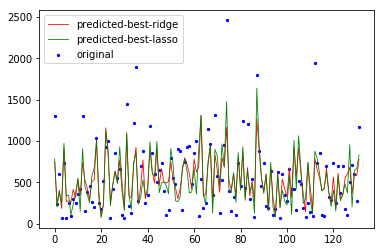

In [23]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, pred11, lw=0.8, color="red", label="predicted-best-ridge")
plt.plot(x_ax, pred8, lw=0.8, color="green", label="predicted-best-lasso")
plt.legend()
plt.show()